In [1]:
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [2]:
# seed 
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## Data
- Replicated transformation from resnet paper
- We follow the simple data augmentation in [24] for training: 4 pixels are padded on each side,
and a 32×32 crop is randomly sampled from the padded
image or its horizontal flip. For testing, we only evaluate
the single view of the original 32×32 image.

In [3]:
# load cifar dataset from data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5, test_batch


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_data():
    data = []
    labels = []
    for i in range(1, 6):
        batch = unpickle(f'./cifar10/cifar-10-batches-py/data_batch_{i}')
        data.append(batch[b'data'])
        labels += batch[b'labels']
    batch = unpickle('./cifar10/cifar-10-batches-py/test_batch')
    data.append(batch[b'data'])
    labels += batch[b'labels']
    data = np.concatenate(data)
    data = data.reshape(data.shape[0], 3, 32, 32)
    data = data.transpose((0, 2, 3, 1))
    return data, labels

data, labels = load_cifar10_data()
print(data.shape)

(60000, 32, 32, 3)


In [4]:
# load cifar10 dataset
trainTransform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainTransform_alex = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testTransform_alex = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
# split data into train, validation and test with 70%, 10%, 20%, make trainloader, validloader, testloader

train_data, test_data, train_label, test_label = train_test_split(data, labels, test_size=0.2, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data, train_label, test_size=0.125, random_state=42)

# aplly trainTransform to train_data and testTransform to test_data, valid_data


class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            # convert numpy array to PIL image
            image = image.astype(np.uint8)
            image = transforms.ToPILImage()(image)
            image = self.transform(image)
        return image, label

def get_train_val_test(batch_size, trainTransform, testTransform):

    train_dataset = CifarDataset(train_data, train_label, trainTransform)
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    valid_dataset = CifarDataset(valid_data, valid_label, testTransform)
    validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    test_dataset = CifarDataset(test_data, test_label, testTransform)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return trainloader, validloader, testloader


## Train Function

In [6]:
def trainFunc(model, trainloader, optimizer, criteria, device, log_file):
    # return loss, accuracy, and number of correct predictions, for each batch
    model.train()
    train_loss = []
    train_acc = []
    for i, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criteria(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        _, predicted = outputs.max(1)
        correct = predicted.eq(targets).sum().item()
        train_acc.append(correct)
        # print accuracy and loss for each batch
        # print('Train: Batch: %d, Loss: %.3f, Accuracy: %.3f' % (i, loss.item(), correct / len(targets)))
        log_file.write('Train: Batch: %d, Loss: %.3f, Accuracy: %.3f\n' % (i, loss.item(), correct / len(targets)) )
    return train_loss, train_acc

## Test Function

In [7]:
def testFunc(model, testloader, criteria, device):
    # return loss, accuracy, and number of correct predictions, for each batch
    model.eval()
    total_loss = 0
    total_correct = 0
    total_data = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criteria(outputs, targets)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_data += targets.size(0)
    # print accuracy and loss for each batch
    return total_loss / len(testloader), total_correct / total_data

In [8]:
# train and test model, save train_loss, train _acc for each bach, test_loss, test_acc for each epoch as log file
def trainModel(model, trainloader, validloader, testloader, optimizer, criteria, scheduler, device, res_dir, exp_name, EPOCHS):
    log_file = open(f'{res_dir}/{exp_name}/log.txt', 'w')

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []

    # save best model
    best_acc = 0
    bestAcc_epoch = 0
    best_model = None

    # start time
    start_time = time.time()
    for epoch in range(EPOCHS):
        print(f'Epoch: {epoch}')
        log_file.write(f'Epoch: {epoch}\n')
        train_loss_, train_acc_ = trainFunc(model, trainloader, optimizer, criteria, device, log_file)
        scheduler.step()
        train_loss.extend(train_loss_)
        train_acc.extend(train_acc_)
        valid_loss_, valid_acc_ = testFunc(model, validloader, criteria, device)
        valid_loss.append(valid_loss_)
        valid_acc.append(valid_acc_)
        test_loss_, test_acc_ = testFunc(model, testloader, criteria, device)
        test_loss.append(test_loss_)
        test_acc.append(test_acc_)

        if test_acc_ > best_acc:
            best_acc = test_acc_
            bestAcc_epoch = epoch
            best_model = model.state_dict()
            torch.save(best_model, f'{res_dir}/{exp_name}/best_model.pth')

        # print epoch, train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc
        print(f'Epoch: {epoch}, Train Loss: {np.mean(train_loss_)}, Train Accuracy: {np.sum(train_acc_) / len(train_data)}, Validation Loss: {valid_loss_}, Validation Accuracy: {valid_acc_}, Test Loss: {test_loss_}, Test Accuracy: {test_acc_}')
        log_file.write(f'Epoch: {epoch}, Train Loss: {np.mean(train_loss_)}, Train Accuracy: {np.sum(train_acc_) / len(train_data)}, Validation Loss: {valid_loss_}, Validation Accuracy: {valid_acc_}, Test Loss: {test_loss_}, Test Accuracy: {test_acc_}\n')

    # save model
    torch.save(model.state_dict(), f'{res_dir}/{exp_name}/model.pth')

    log_file.write(f'Best Accuracy: {best_acc}, Epoch: {bestAcc_epoch}\n')
    
    # end time
    end_time = time.time()

    log_file.write(f'Training Time: {end_time - start_time}\n')

    log_file.close()


## Resnet50 Training

In [9]:
BATCH_SIZE = 256
EPOCHS = 300

In [10]:
# load resnet50 model from hub
resnet_model = torch.hub.load('pytorch/vision', 'resnet50', weights=None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model.to(device)

model_name = 'resnet50_test2'

trainloader, validloader, testloader = get_train_val_test(BATCH_SIZE, trainTransform, testTransform)

# print the numer of samples in train, validation, test
print('Train size:', len(trainloader.dataset))
print('Validation size:', len(validloader.dataset))
print('Test size:', len(testloader.dataset))

Using cache found in /export/home/darpan/.cache/torch/hub/pytorch_vision_main


Train size: 42000
Validation size: 6000
Test size: 12000


## Loss function, Optimizers, Schedulers
- Refrence from resnet paper
- We use a weight decay of 0.0001 and momentum of 0.9,
and adopt the weight initialization in [13] and BN [16] but
with no dropout.
- https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10

In [11]:
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
BASE_LR = 0.0001
MAX_LR = 0.1
STEP_SIZE_UP = 2000
CYCLE_MOMENTUM = False

opt_name = 'SGD'
scheduler_name = 'CyclicLR'

criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=BASE_LR, max_lr=MAX_LR, step_size_up=STEP_SIZE_UP, cycle_momentum=CYCLE_MOMENTUM)

In [12]:
# make resuts directory and save configuration
res_dir = './results'
exp_name = f'{model_name}_{opt_name}_{scheduler_name}'
os.makedirs(f'{res_dir}/{exp_name}', exist_ok=True)

# save training configuration as json
config = {
    'model': model_name,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'optimizer': opt_name,
    'learning_rate': LEARNING_RATE,
    'momentum': MOMENTUM,
    'weight_decay': WEIGHT_DECAY,
    'scheduler': scheduler_name,
    'base_lr': BASE_LR,
    'max_lr': MAX_LR,
    'step_size_up': STEP_SIZE_UP,
    'cycle_momentum': CYCLE_MOMENTUM,
}

with open(f'{res_dir}/{exp_name}/config.json', 'w') as f:
    json.dump(config, f)

In [ ]:
# uncomment while training

# trainModel(resnet_model, trainloader, validloader, testloader, optimizer, criteria, scheduler, device, res_dir, exp_name, EPOCHS)

## AlexNet Training

In [13]:
# load alexnet model from hub
alexnet_model = torch.hub.load('pytorch/vision', 'alexnet', weights=None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alexnet_model.to(device)

model_name = 'alexnet_test2'

trainloader, validloader, testloader = get_train_val_test(BATCH_SIZE, trainTransform_alex, testTransform_alex)

# print the numer of samples in train, validation, test
print('Train size:', len(trainloader.dataset))
print('Validation size:', len(validloader.dataset))
print('Test size:', len(testloader.dataset))

Using cache found in /export/home/darpan/.cache/torch/hub/pytorch_vision_main


Train size: 42000
Validation size: 6000
Test size: 12000


In [14]:
# using the same config for loss, optimizer, scheduler
criteria = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=BASE_LR, max_lr=MAX_LR, step_size_up=STEP_SIZE_UP, cycle_momentum=CYCLE_MOMENTUM)

In [15]:
# make resuts directory and save configuration
res_dir = './results'
exp_name = f'{model_name}_{opt_name}_{scheduler_name}'
os.makedirs(f'{res_dir}/{exp_name}', exist_ok=True)

# save training configuration as json
config = {
    'model': model_name,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'optimizer': opt_name,
    'learning_rate': LEARNING_RATE,
    'momentum': MOMENTUM,
    'weight_decay': WEIGHT_DECAY,
    'scheduler': scheduler_name,
    'base_lr': BASE_LR,
    'max_lr': MAX_LR,
    'step_size_up': STEP_SIZE_UP,
    'cycle_momentum': CYCLE_MOMENTUM,
}

with open(f'{res_dir}/{exp_name}/config.json', 'w') as f:
    json.dump(config, f)


In [ ]:
# uncomment while training

# trainModel(alexnet_model, trainloader, validloader, testloader, optimizer, criteria, scheduler, device, res_dir, exp_name, EPOCHS)

In [17]:
# Open log file, get train_loss, train_acc, test_loss, test_acc, best_acc, bestAcc_epoch
def get_stats(log_path):
    log_file = open(log_path, 'r')
    lines = log_file.readlines()
    log_file.close()

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    test_loss = []
    test_acc = []

    for line in lines:
        if 'Epoch' in line and len(line.split()) > 5:
            line = line.split()
            epoch = int(line[1][:-1])
            train_loss.append(float(line[4][:-1]))
            train_acc.append(float(line[7][:-1]))
            val_loss.append(float(line[10][:-1]))
            val_acc.append(float(line[13][:-1]))
            test_loss.append(float(line[16][:-1]))
            test_acc.append(float(line[19]))
    
    best_acc = float(lines[-1].split()[2][:-1])
    best_epoch = int(lines[-1].split()[4])

    return train_loss, train_acc, val_loss, val_acc, test_loss, test_acc, best_acc, best_epoch

In [18]:
resnet_log_path = './results/resnet50_SGD_CyclicLR/log.txt'
alexnet_log_path = './results/alexnet_SGD_CyclicLR/log.txt'

resnet_train_loss, resnet_train_acc, resnet_val_loss, resnet_val_acc, resnet_test_loss, resnet_test_acc, resnet_best_acc, resnet_best_epoch = get_stats(resnet_log_path)
alexnet_train_loss, alexnet_train_acc, alexnet_val_loss, alexnet_val_acc, alexnet_test_loss, alexnet_test_acc, alexnet_best_acc, alexnet_best_epoch = get_stats(alexnet_log_path)

In [19]:
# load the model trained
resnet_model = torch.hub.load('pytorch/vision', 'resnet50', weights=None)
resnet_model.load_state_dict(torch.load('./results/resnet50_SGD_CyclicLR/best_model.pth'))

alexnet_model = torch.hub.load('pytorch/vision', 'alexnet', weights=None)
alexnet_model.load_state_dict(torch.load('./results/alexnet_SGD_CyclicLR/best_model.pth'))

Using cache found in /export/home/darpan/.cache/torch/hub/pytorch_vision_main
/tmp/ipykernel_2967685/3679376562.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_mo

<All keys matched successfully>

## Model summary and parameters

In [20]:
# model summary
print('Resnet Model')
resnet_model.to(device)
summary(resnet_model, (3, 32, 32))

# print number of parameters
print('Resnet Model Parametrs: -', end=' ')
print(sum(p.numel() for p in resnet_model.parameters() if p.requires_grad))

Resnet Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14      

In [21]:
# model summary
print('Alexnet Model')
alexnet_model.to(device)

summary(alexnet_model, (3, 224, 224))

# print number of parameters
print('Alexnet Model Parametrs: -', end=' ')
print(sum(p.numel() for p in alexnet_model.parameters() if p.requires_grad))

Alexnet Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14     

## Que 1 (a)

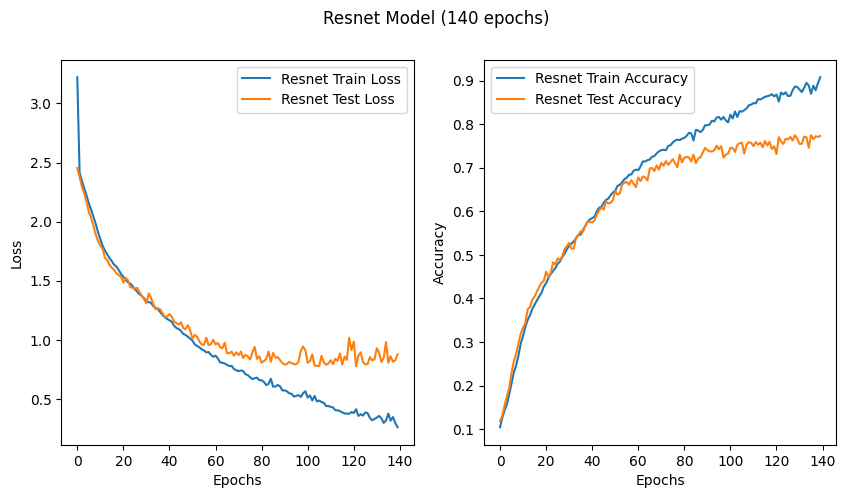

In [22]:
# plot train and test error, accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_train_loss, label='Resnet Train Loss')
plt.plot(resnet_test_loss, label='Resnet Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_train_acc, label='Resnet Train Accuracy')
plt.plot(resnet_test_acc, label='Resnet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('Resnet Model (140 epochs)')
plt.show()


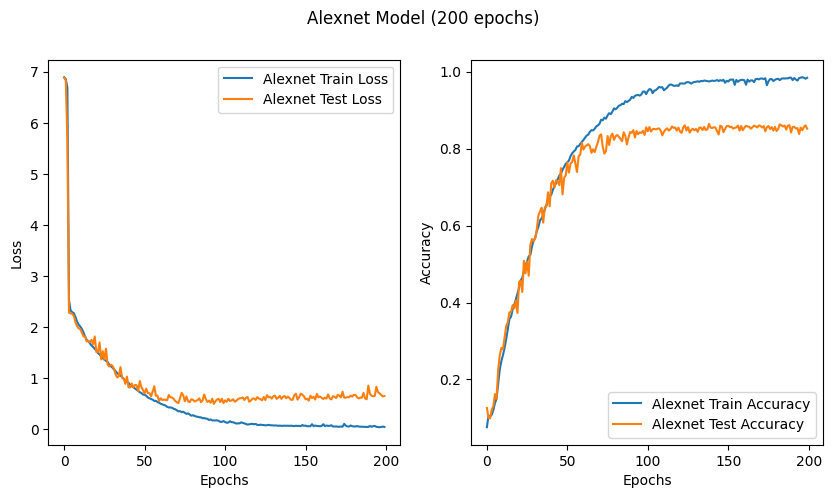

In [23]:
# alexnet model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(alexnet_train_loss, label='Alexnet Train Loss')
plt.plot(alexnet_test_loss, label='Alexnet Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alexnet_train_acc, label='Alexnet Train Accuracy')
plt.plot(alexnet_test_acc, label='Alexnet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('Alexnet Model (200 epochs)')
plt.show()

## Que 1 (b)

### Resnet

In [24]:
# resnet model
# get activations maps from conv layer of layer 2, 3, 4
def get_activation_maps(model, layer, data, device):
    activation_maps = []
    model.to(device)
    model.eval()
    def hook(module, input, output):
        activation_maps.append(output)
    hook_handle = layer.register_forward_hook(hook)
    with torch.no_grad():
        model(data.to(device))
    hook_handle.remove()
    return activation_maps

def plot_activation_map(model, data, model_name):

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(data)
    plt.title('Input Image')
    # add batch dimension
    # make torch tensor and permute dimensions
    

    if (model_name=='resnet'):
        layer1 = resnet_model.conv1
        layer2 = resnet_model.layer1[0].conv2
        layer3 = resnet_model.layer2[0].conv2
        data = torch.tensor(data).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)
    else:
        layer1 = alexnet_model.features[1]
        layer2 = alexnet_model.features[3]
        layer3 = alexnet_model.features[6]
        # upsample image to 224x224
        data = torch.tensor(data).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)
        data = torch.nn.functional.interpolate(data, size=(224, 224), mode='bilinear', align_corners=False)


    activation_maps1 = get_activation_maps(model, layer1, data, device)
    activation_maps2 = get_activation_maps(model, layer2, data, device)
    activation_maps3 = get_activation_maps(model, layer3, data, device)

    # plot activation maps
    plt.subplot(1, 4, 2)
    plt.imshow(activation_maps1[0][0][0].cpu().numpy())
    plt.title('Activation Map 1')
    plt.subplot(1, 4, 3)
    plt.imshow(activation_maps2[0][0][0].cpu().numpy())
    plt.title('Activation Map 2')
    plt.subplot(1, 4, 4)
    plt.imshow(activation_maps3[0][0][0].cpu().numpy())
    plt.title('Activation Map 3')
    plt.show()


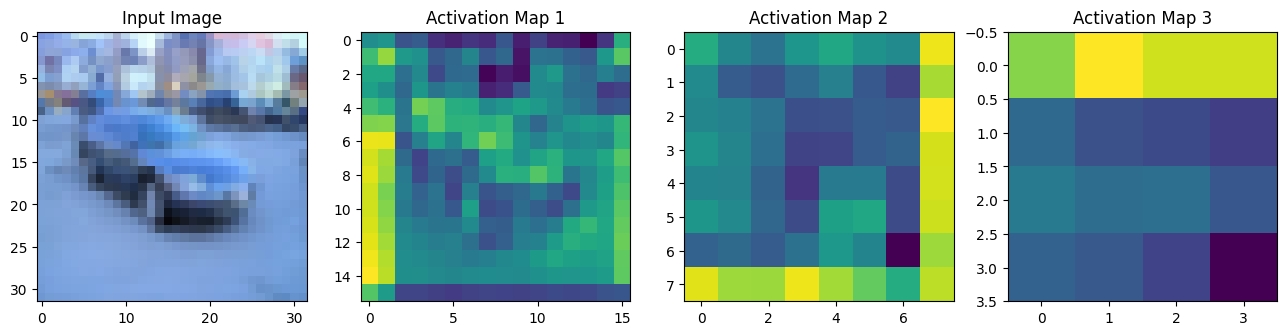

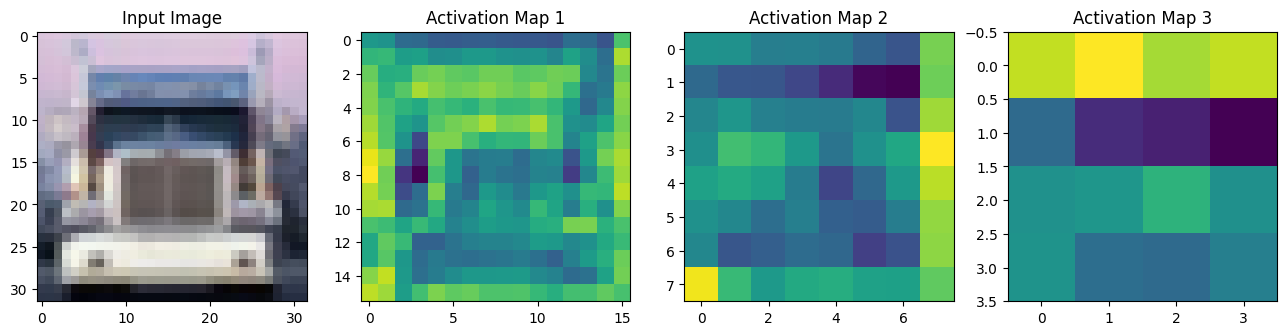

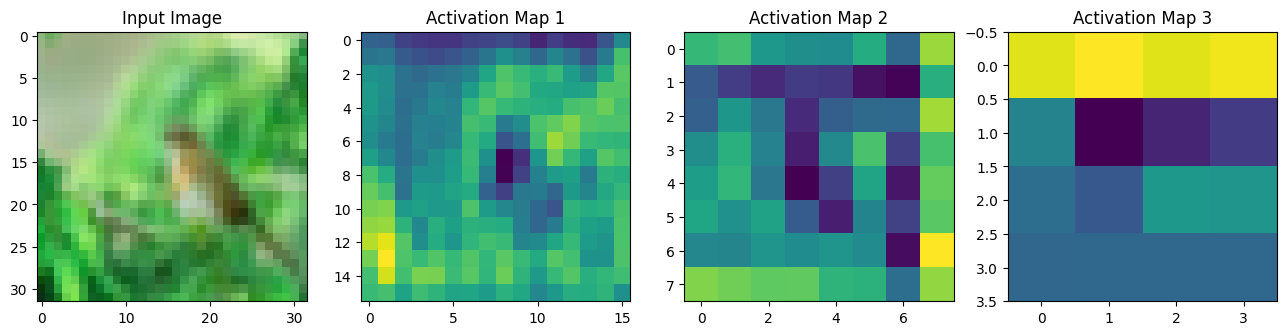

In [25]:
# plot activation map for 3 images in test data
for i in range(3):
    plot_activation_map(resnet_model, test_data[i], 'resnet')

### Alexnet

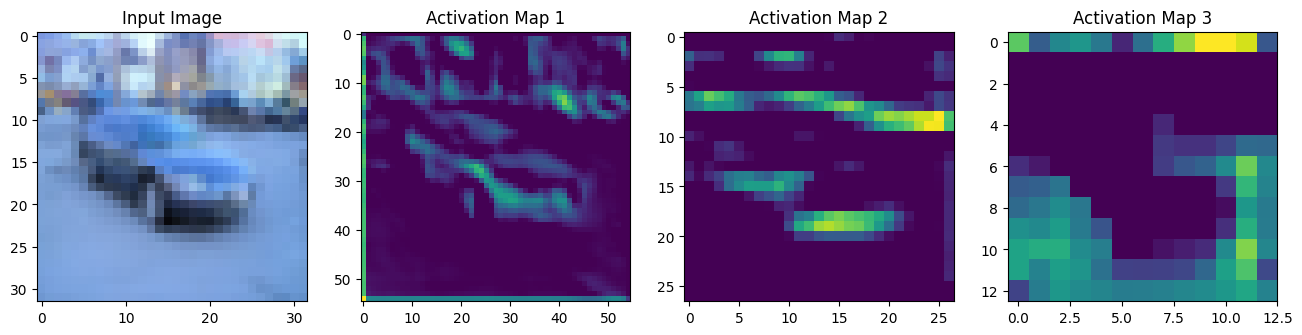

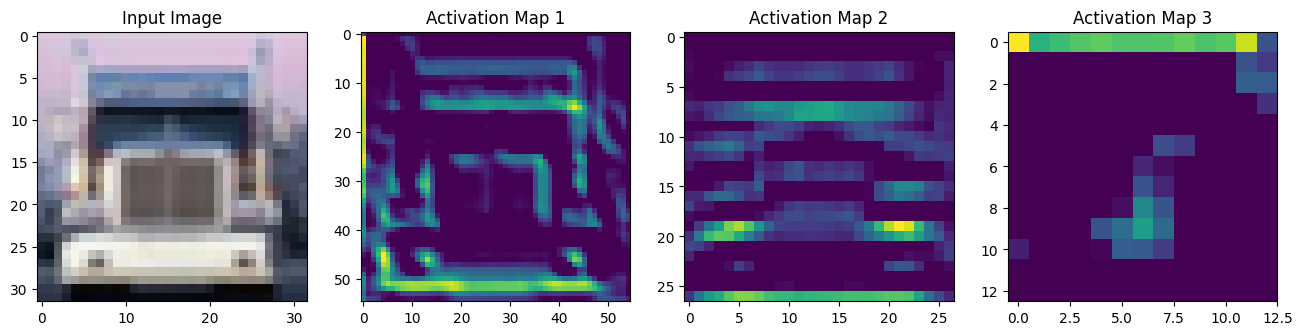

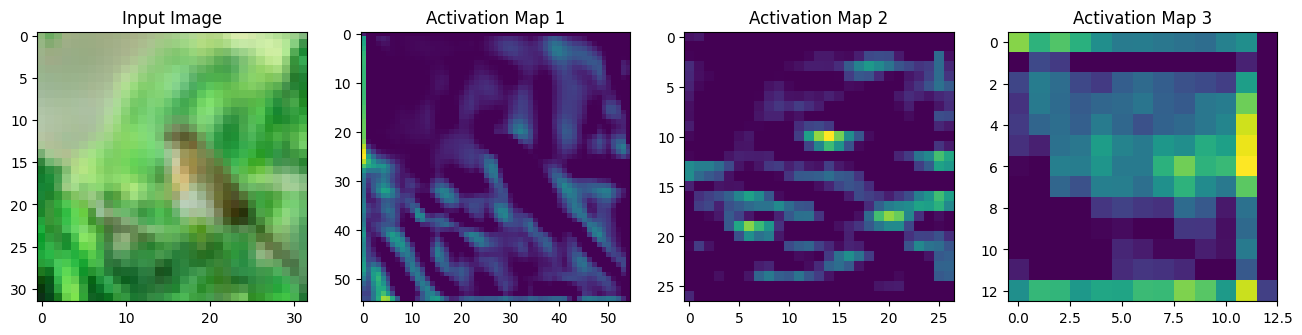

In [26]:
for i in range(3):
    plot_activation_map(alexnet_model, test_data[i], 'alexnet')

## Que 1 (c)

In [27]:
# report accuracy on test set
print(f'Resnet trained for 140 epochs')
print(f'Resnet Best Accuracy: {resnet_best_acc}, Epoch: {resnet_best_epoch}')

print(f'Alexnet trined for 200 epochs')
print(f'Alexnet Best Accuracy: {alexnet_best_acc}, Epoch: {alexnet_best_epoch}')

Resnet trained for 140 epochs
Resnet Best Accuracy: 0.7746666666666666, Epoch: 135
Alexnet trined for 200 epochs
Alexnet Best Accuracy: 0.8643333333333333, Epoch: 138


- Trained for fixed number of epochs, models were still improving.
- Choice of learning rate, lr_scheduler parameters were same for both models.

## Que 1 (d)

In [28]:
# make set of a set of images from test set, containing 10 images from each class
def get_class_images(testloader):
    class_images = {}
    for i in range(10):
        class_images[i] = []
    for i, (images, labels) in enumerate(testloader):
        for j in range(len(labels)):
            if len(class_images[labels[j].item()]) < 10:
                class_images[labels[j].item()].append(images[j])
    return class_images

In [29]:
# get output of resnet model after Bottleneck-172 layer
def get_bottleneck_feat(model, class_images):
    bottonneck_features = []
    def hook_fn(module, input, output):
        bottonneck_features.append(output.detach().cpu().numpy())

    model.layer4[2].register_forward_hook(hook_fn)

    # get output of resnet model after Bottleneck-172 layer
    def get_bottleneck_features(model, class_images):
        model.eval()
        with torch.no_grad():
            for i in range(10):
                for j in range(10):
                    image = class_images[i][j].unsqueeze(0).to(device)
                    output = model(image)
        return bottonneck_features

    bottleneck_features = get_bottleneck_features(resnet_model, class_images)
    return bottleneck_features

In [30]:
# get bottleneck features for alexnet model
def get_bottleneck_feat_alexnet(model, class_images):
    bottonneck_features = []
    def hook_fn(module, input, output):
        bottonneck_features.append(output.detach().cpu().numpy())

    hook = model.features[10].register_forward_hook(hook_fn)

    # get output of resnet model after feature-10 layer
    def get_bottleneck_features(model, class_images):
        model.eval()
        with torch.no_grad():
            for i in range(10):
                for j in range(10):
                    image = class_images[i][j].unsqueeze(0).to(device)
                    output = model(image)
        return bottonneck_features

    bottleneck_features = get_bottleneck_features(alexnet_model, class_images)
    return bottleneck_features

In [31]:
def tsne_plot(bottleneck_features_start, bottleneck_features_end):
    tsne = TSNE(n_components=2, random_state=seed)
    # reshape to 1D array
    bottleneck_features_start = np.array(bottleneck_features_start).reshape(len(bottleneck_features_start), -1)
    bottleneck_features_end = np.array(bottleneck_features_end).reshape(len(bottleneck_features_end), -1)

    tsne_start = tsne.fit_transform(bottleneck_features_start)
    tsne_end = tsne.fit_transform(bottleneck_features_end)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    for i in range(10):
        plt.scatter(tsne_start[i*10:(i+1)*10, 0], tsne_start[i*10:(i+1)*10, 1], label=f'Class {i}')
    plt.title('Before Training')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(10):
        plt.scatter(tsne_end[i*10:(i+1)*10, 0], tsne_end[i*10:(i+1)*10, 1], label=f'Class {i}')
    plt.title('After Training')
    plt.legend()

    plt.suptitle('TSNE plot of Bottleneck features')
    plt.show()


In [32]:
# train model for 1 epoch
resnet_model = torch.hub.load('pytorch/vision', 'resnet50', weights=None).to(device)
trainloader, validloader, testloader = get_train_val_test(BATCH_SIZE, trainTransform, testTransform)
trainModel(resnet_model, trainloader, validloader, testloader, optimizer, criteria, scheduler, device, res_dir, exp_name, 1)

# get class images
class_images = get_class_images(testloader)

# get bottleneck features
bottleneck_features_start = get_bottleneck_feat(resnet_model, class_images)

# load trained weights
resnet_model = torch.hub.load('pytorch/vision', 'resnet50', weights=None).to(device)
resnet_model.load_state_dict(torch.load('./results/resnet50_SGD_CyclicLR/best_model.pth'))

# get bottleneck features
bottleneck_features_end = get_bottleneck_feat(resnet_model, class_images)

Using cache found in /export/home/darpan/.cache/torch/hub/pytorch_vision_main


Epoch: 0
Epoch: 0, Train Loss: 7.828468244726007, Train Accuracy: 0.0, Validation Loss: 7.6579475204149885, Validation Accuracy: 0.0, Test Loss: 7.644385500157133, Test Accuracy: 0.0


Using cache found in /export/home/darpan/.cache/torch/hub/pytorch_vision_main
/tmp/ipykernel_2967685/3272157393.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_m

## Resnet 

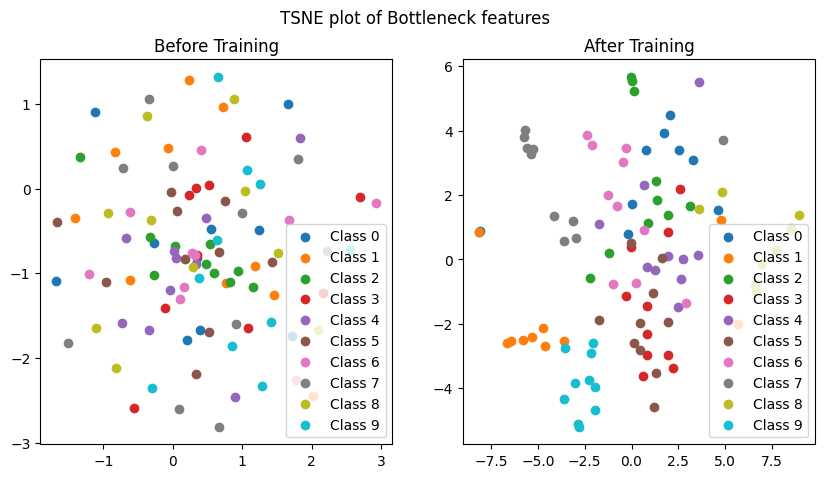

In [33]:
tsne_plot(bottleneck_features_start, bottleneck_features_end)

In [34]:
# train alexnet model for 1 epoch
alexnet_model = torch.hub.load('pytorch/vision', 'alexnet', weights=None).to(device)
trainloader, validloader, testloader = get_train_val_test(BATCH_SIZE, trainTransform_alex, testTransform_alex)
trainModel(alexnet_model, trainloader, validloader, testloader, optimizer, criteria, scheduler, device, res_dir, exp_name, 1)

class_images = get_class_images(testloader)

# get bottleneck features
bottleneck_features_start = get_bottleneck_feat_alexnet(alexnet_model, class_images)

# load trained weights
alexnet_model = torch.hub.load('pytorch/vision', 'alexnet', weights=None).to(device)
alexnet_model.load_state_dict(torch.load('./results/alexnet_SGD_CyclicLR/best_model.pth'))

# get bottleneck features
bottleneck_features_end = get_bottleneck_feat_alexnet(alexnet_model, class_images)

Using cache found in /export/home/darpan/.cache/torch/hub/pytorch_vision_main


Epoch: 0
Epoch: 0, Train Loss: 6.904554881471576, Train Accuracy: 7.142857142857143e-05, Validation Loss: 6.905036270618439, Validation Accuracy: 0.0, Test Loss: 6.905236010855817, Test Accuracy: 0.0


Using cache found in /export/home/darpan/.cache/torch/hub/pytorch_vision_main
/tmp/ipykernel_2967685/1779456488.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  alexnet_

## Alexnet

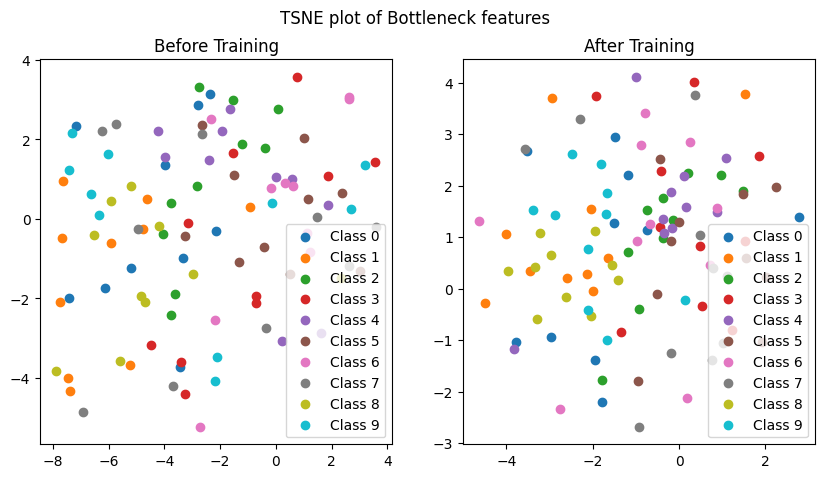

In [35]:
tsne_plot(bottleneck_features_start, bottleneck_features_end)

## Que 1 (e)
- Number of parameters:
    -  Resnet50  -> 25.557 M  
    -  Alexnet   -> 61.1 M
- Time taking for one-epoch (train + val)
    -  Resnet50  -> 24.46 sec
    -  Alexnet   -> 120 sec
- Number of epochs trained
    -  Resnet50  -> 140
    -  Alexnet   -> 200

- Will choose resnet50, as it takes less time to train and also has less parameters in comparision to Alexnet